In [7]:
import pandas as pd

# Load your CSV
df = pd.read_csv('Combined Data.csv')  # Change path if needed

# Drop index column
df.drop(columns=['Unnamed: 0'], inplace=True)

# Drop missing values
df.dropna(subset=['statement'], inplace=True)

# View data
print(df.info())
display(df.head())  # Jupyter-friendly display

# Sample 2 statements per 'status' group without DeprecationWarning
sampled = df.groupby('status').apply(lambda x: x.sample(2), include_groups=False)[['statement', 'status']]
display(sampled)


<class 'pandas.core.frame.DataFrame'>
Index: 52681 entries, 0 to 53042
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   statement  52681 non-null  object
 1   status     52681 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB
None


,statement,status
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,I've shifted my focus to something else but I'...,Anxiety
4,"I'm restless and restless, it's been a month n...",Anxiety


KeyError: "['status'] not in index"

In [5]:
# Class distribution
print(df['status'].value_counts())

# Check for duplicates
print(f'Duplicates: {df.duplicated().sum()}')

# Sample entries per label
df.groupby('status').apply(lambda x: x.sample(2))[['statement', 'status']]


status
Normal                  16343
Depression              15404
Suicidal                10652
Anxiety                  3841
Bipolar                  2777
Stress                   2587
Personality disorder     1077
Name: count, dtype: int64
Duplicates: 1588


C:\Users\AL-SAEED\AppData\Local\Temp\ipykernel_74608\1317948040.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby('status').apply(lambda x: x.sample(2))[['statement', 'status']]


statement  \
status                                                                          
Anxiety              52263  How often do you take benzos? I am not able to...   
                     35203  SO HAPPY I FOUND YOU ALL So i have been agoroh...   
Bipolar              46384  Will You Take Medications For The Rest of Your...   
                     50031  more impulsive stuff Have you guys figured out...   
Depression           40232  i say that i m feeling depressed and instead o...   
                     40773  mizzzidc politely i ask are you mad how dare y...   
Normal               36255             @o_crunk Keep it up, you do good work!   
                     29351  I honestly thought it might be similar to call...   
Personality disorder 51288  Hikikomori condition Have any of you become hi...   
                     50688  Anxiety after the gym Ever since I started goi...   
Stress               28151  Friends and loved ones (who don't have anxiety...   
                     29953  This is my first post on reddit and I am seeki...   
Suicidal             15797  I want to stop thinking about it. I have never...   
                     23378  there are things in my life and problems i lit...   

                                          status  
status                                            
Anxiety              52263               Anxiety  
                     35203               Anxiety  
Bipolar              46384               Bipolar  
                     50031               Bipolar  
Depression           40232            Depression  
                     40773            Depression  
Normal               36255                Normal  
                     29351                Normal  
Personality disorder 51288  Personality disorder  
                     50688  Personality disorder  
Stress               28151                Stress  
                     29953                Stress  
Suicidal             15797              Suicidal  
                     23378              Suicidal

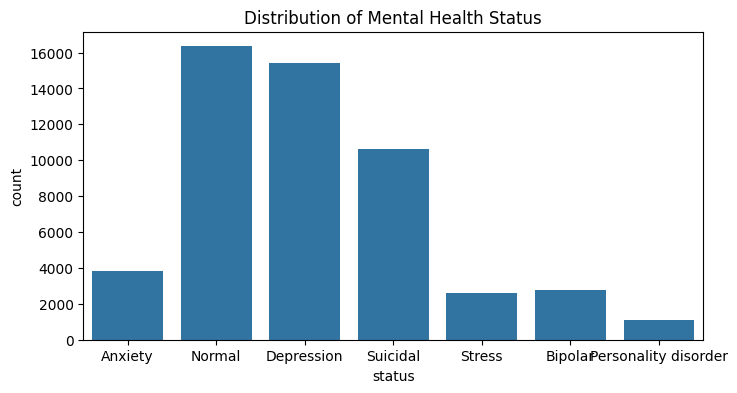

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot class distribution
plt.figure(figsize=(8,4))
sns.countplot(data=df, x='status')
plt.title("Distribution of Mental Health Status")
plt.show()


In [ ]:
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

def clean_text(text):
    text = text.lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(f"[{re.escape(string.punctuation)}]", '', text)
    text = re.sub(r'\w*\d\w*', '', text)
    return text

df['clean_text'] = df['statement'].apply(clean_text)

# Split data
X_train, X_test, y_train, y_test = train_test_split(df['clean_text'], df['status'], test_size=0.2, random_state=42)

# Vectorize text using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)


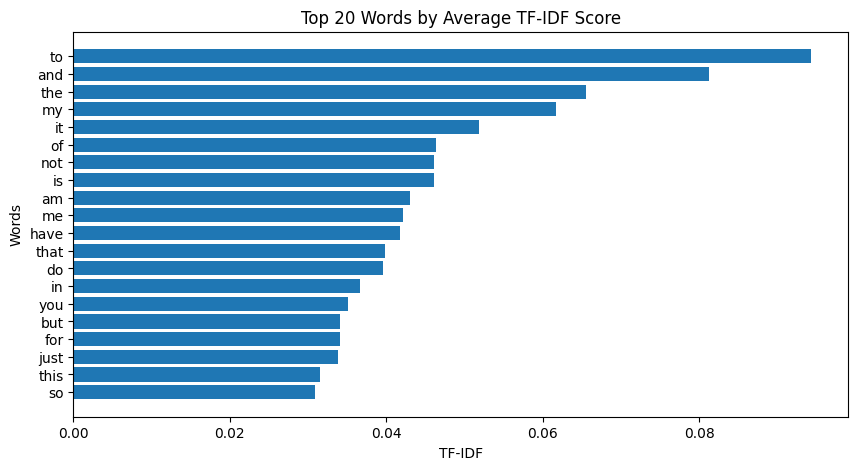

In [ ]:
import numpy as np

# Get feature names and their average TF-IDF score across all documents
feature_names = vectorizer.get_feature_names_out()
mean_tfidf = X_train_tfidf.mean(axis=0).A1
top_indices = np.argsort(mean_tfidf)[-20:]  # Top 20 words

# Plot
plt.figure(figsize=(10,5))
plt.barh([feature_names[i] for i in top_indices], mean_tfidf[top_indices])
plt.title("Top 20 Words by Average TF-IDF Score")
plt.xlabel("TF-IDF")
plt.ylabel("Words")
plt.show()


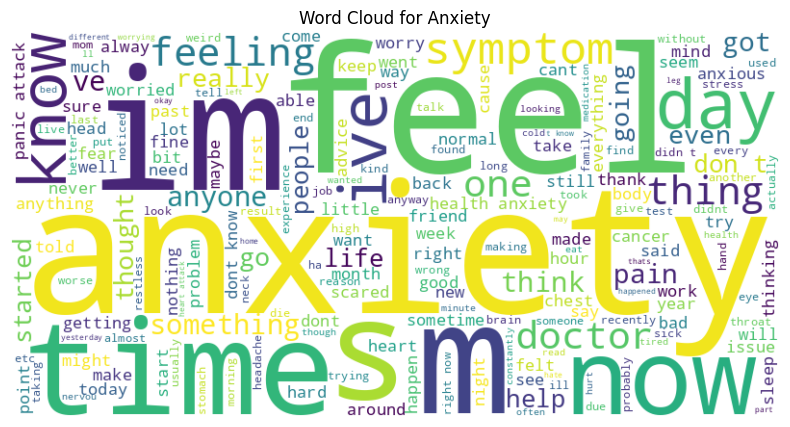

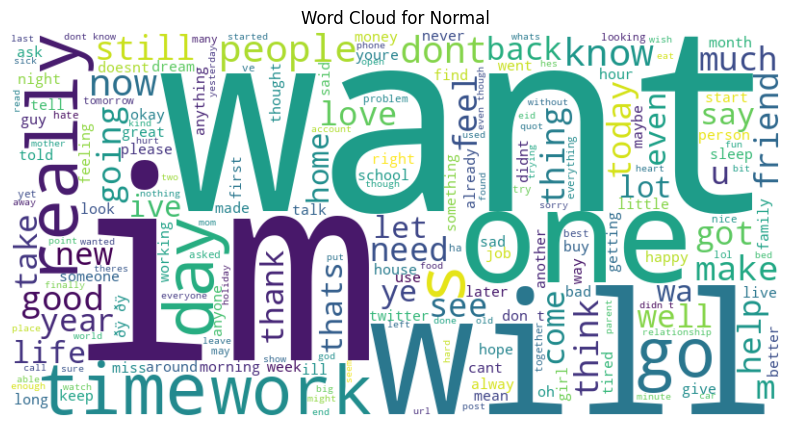

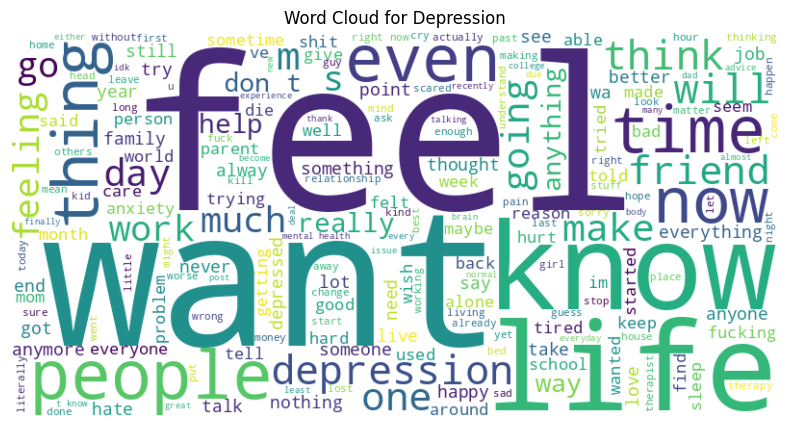

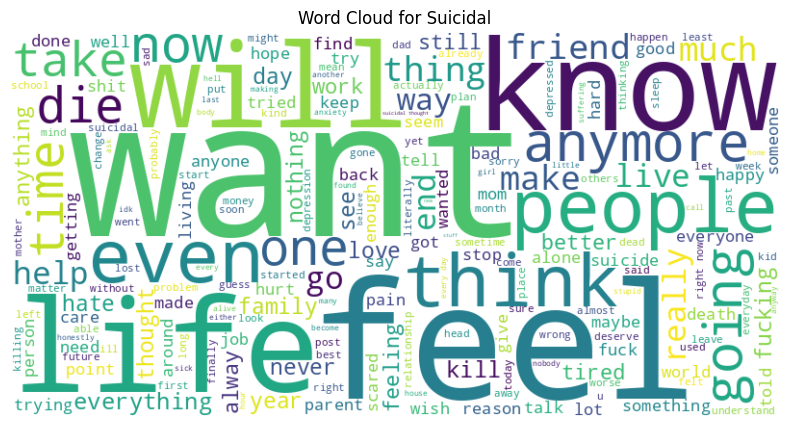

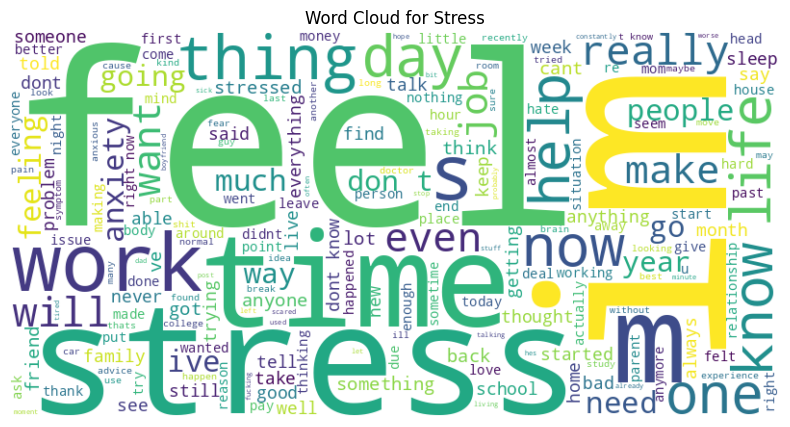

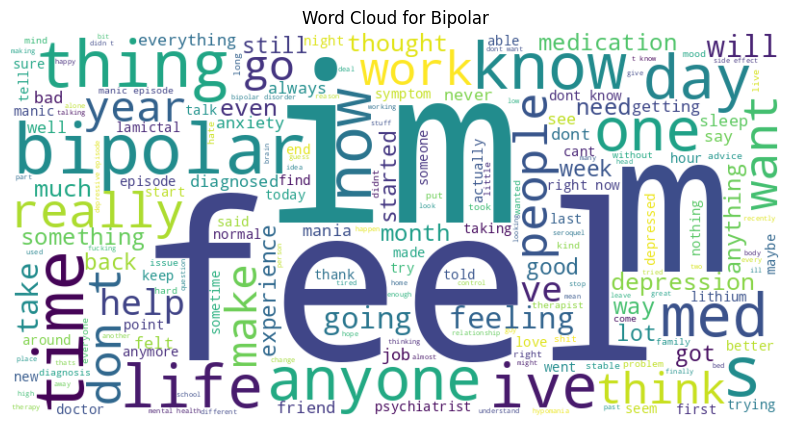

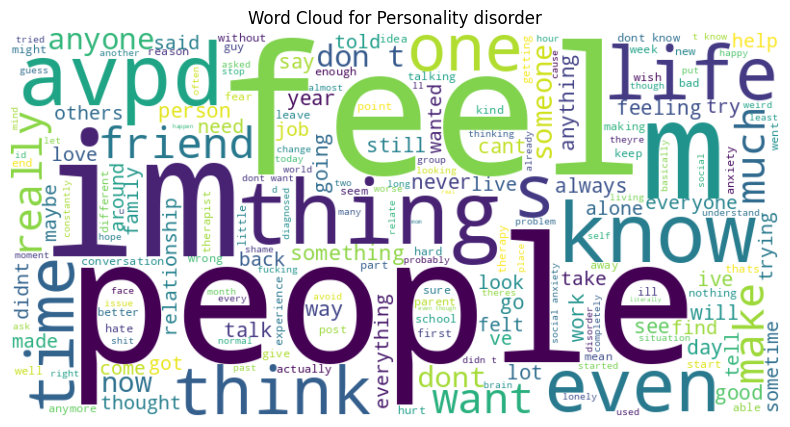

In [ ]:
from wordcloud import WordCloud

# Create word clouds for each class
for label in df['status'].unique():
    text = " ".join(df[df['status'] == label]['clean_text'])
    wc = WordCloud(width=800, height=400, background_color='white').generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Word Cloud for {label}")
    plt.show()


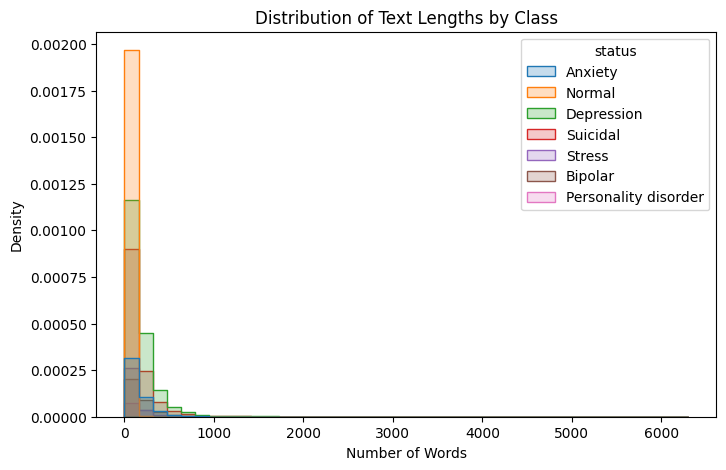

In [ ]:
df['text_length'] = df['clean_text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(8,5))
sns.histplot(data=df, x='text_length', bins=40, hue='status', element='step', stat='density')
plt.title("Distribution of Text Lengths by Class")
plt.xlabel("Number of Words")
plt.ylabel("Density")
plt.show()


In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Reduce to 50 dimensions first (for performance), then to 2 for plotting
pca = PCA(n_components=50, random_state=42)
X_reduced = pca.fit_transform(X_train_tfidf.toarray())

# Then apply t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_embedded = tsne.fit_transform(X_reduced)


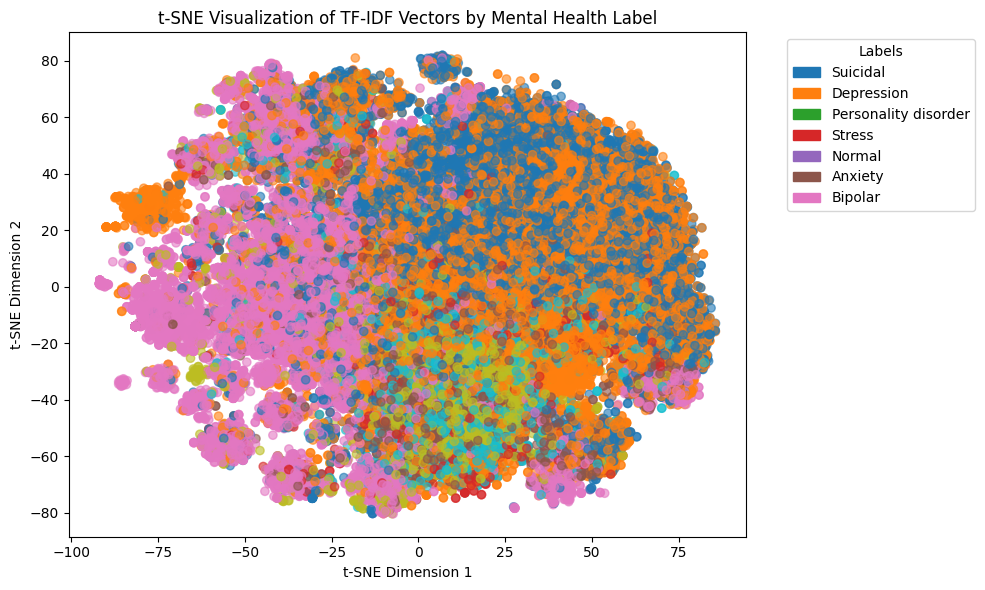

In [ ]:
import matplotlib.pyplot as plt

# Convert y_train to a categorical color
labels = y_train.reset_index(drop=True)
label_names = labels.unique()
label_to_color = {label: idx for idx, label in enumerate(label_names)}
colors = labels.map(label_to_color)

plt.figure(figsize=(10, 6))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=colors, cmap='tab10', alpha=0.6)
plt.title("t-SNE Visualization of TF-IDF Vectors by Mental Health Label")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")

# Add legend
import matplotlib.patches as mpatches
handles = [mpatches.Patch(color=plt.cm.tab10(i), label=label) for i, label in enumerate(label_names)]
plt.legend(handles=handles, title="Labels", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [ ]:
!pip install transformers datasets scikit-learn --quiet


In [ ]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizerFast, BertForSequenceClassification, Trainer, TrainingArguments
from transformers import DataCollatorWithPadding
from datasets import Dataset


In [ ]:
# Load CSV
df = pd.read_csv('/content/Combined Data.csv')
df.drop(columns=['Unnamed: 0'], inplace=True)
df.dropna(subset=['statement'], inplace=True)

# Encode labels
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['status'])

# Train/test split
train_df, test_df = train_test_split(df[['statement', 'label']], test_size=0.2, stratify=df['label'], random_state=42)

# Convert to Hugging Face Dataset
train_ds = Dataset.from_pandas(train_df)
test_ds = Dataset.from_pandas(test_df)


In [ ]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

def tokenize_function(example):
    return tokenizer(example["statement"], truncation=True)

train_ds = train_ds.map(tokenize_function, batched=True)
test_ds = test_ds.map(tokenize_function, batched=True)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Map:   0%|          | 0/42144 [00:00<?, ? examples/s]

Map:   0%|          | 0/10537 [00:00<?, ? examples/s]

In [ ]:
num_labels = df['label'].nunique()
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
training_args = TrainingArguments(
    output_dir="./bert-output",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy"
)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}


In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

trainer.train()


<ipython-input-10-d1fc70054d09>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: aahilsial12 (aahilsial12-me) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [ ]:
metrics = trainer.evaluate()
print(metrics)
